In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric built in GCN layer, the `GCNConv`. In this Colab we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layers directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.  
在 Colab 2 中，我们使用内置于 GCN 层的 PyTorch Geometric GCNConv 构建了 GNN 模型。 在这个 Colab 中，我们将直接实现 GraphSAGE (Hamilton et al. (2017)) 和 GAT (Veličković et al. (2018)) 层。 然后我们将在 CORA 数据集上运行我们的模型，这是一个标准的引文网络基准数据集。

We will then use [DeepSNAP](https://snap.stanford.edu/deepsnap/), a Python library assisting efficient deep learning on graphs, to split the graphs in different settings and apply dataset transformations.  
然后，我们将使用 DeepSNAP，这是一个 Python 库，可帮助对图进行高效的深度学习，在不同的设置中拆分图并应用数据集转换。

At last, using DeepSNAP transductive link prediction split functionality, we will construct a simple GNN model on the edge property predition (link prediction) task.  
最后，使用 DeepSNAP 转导链接预测拆分功能，我们将在边缘属性预测（链接预测）任务上构建一个简单的 GNN 模型。

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun on Colab 3 :)  
注意：确保顺序运行每个部分中的所有单元格，以便中间变量/包会延续到下一个单元格

在 Colab 3 上玩得开心 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.  
您可能需要为此 Colab 使用 GPU。

请单击运行时，然后更改运行时类型。 然后将硬件加速器设置为GPU。

## Installation

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0+cu102


In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html       #1.7.0+cu101
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 5.3MB/s 
     |████████████████████████████████| 1.4MB 5.0MB/s 
     |████████████████████████████████| 225kB 7.8MB/s 
     |████████████████████████████████| 235kB 49.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 


In [4]:
import torch_geometric
torch_geometric.__version__

'1.7.2'

# 1 GNN Layers

## Implementing Layer Modules

In colab 2, we implemented a network using GCN in node and graph classification tasks. However, the GCN module we used in colab 2 is from the official library. For this problem, we will provide you with a general Graph Neural Network Stack, where you'll be able to plugin your own modules of GraphSAGE and GATs. We will use our implementations to complete node classification on CORA, which is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node.   
在 colab 2 中，我们在节点和图分类任务中使用 GCN 实现了一个网络。 但是，我们在 colab 2 中使用的 GCN 模块来自官方库。 对于这个问题，我们将为您提供一个通用的 Graph Neural Network Stack，您可以在其中插入您自己的 GraphSAGE 和 GAT 模块。 我们将使用我们的实现来完成 CORA 上的节点分类，CORA 是一个标准的引文网络基准数据集。 在这个数据集中，节点对应于文档，边对应于无向引用。 每个节点都有一个类标签。 节点特征是文档的 bag-or-words 表示的元素。 对于 Cora 数据集，有 2708 个节点、5429 条边、7 个节点预测类以及每个节点 1433 个特征。

## GNN Stack Module

Below is the implementation for a general GNN Module that could plugin any layers, including **GraphSage**, **GAT**, etc. This module is provided for you, and you own **GraphSage** and **GAT** layers will function as components in the GNNStack Module.  
下面是一个通用的 GNN 模块的实现，它可以插入任何层，包括 GraphSage、GAT 等。这个模块是为你提供的，你自己的 GraphSage 和 GAT 层将作为 GNNStack 模块中的组件。

In [5]:
import torch
import torch_scatter    # 通过src和index两个张量来获得一个新的张量。scatter()一般可以用来对标签进行 one-hot 编码，
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional   # 类型检查，防止运行时出现参数和返回值类型不符合。
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear      #PRW：https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)     #GraphSage / GAT
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'    #Python assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常。
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)      # Applies a softmax followed by a logarithm. https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.log_softmax

    def loss(self, pred, label):        # The negative log likelihood loss. https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#nll_loss
        return F.nll_loss(pred, label)    # nll_loss(negative log likelihood loss)：最大似然 / log似然代价函数.CrossEntropyLoss: 交叉熵损失函数。交叉熵描述了两个概率分布之间的距离，当交叉熵越小说明二者之间越接近。

In [6]:
#PRW
eg_ls=nn.LogSoftmax(dim=1)  #dim值是必须要的
eg_tensor=torch.randn(1,2,3)
eg_result=eg_ls(eg_tensor)
print(eg_tensor)
print(eg_result)

tensor([[[ 0.9009, -1.1204, -0.1443],
         [ 0.3708, -0.7835, -0.8754]]])
tensor([[[-0.4628, -0.8757, -0.3929],
         [-0.9929, -0.5388, -1.1241]]])


## GraphSage Implementation

Now let's start working on our own implementation of layers! This part is to get you familiar with how to implement Pytorch layer based on Message Passing. You will be implementing the **forward**, **message** and **aggregate** functions.  
现在让我们开始研究我们自己的层实现！ 这部分是为了让您熟悉如何实现基于消息传递的 Pytorch 层。 您将实现转发、消息和聚合函数。

Generally, the **forward** function is where the actual message passing is conducted. All logic in each iteration happens in **forward**, where we'll call **propagate** function to propagate information from neighbor nodes to central nodes.  So the general paradigm will be pre-processing -> propagate -> post-processing.  
通常，转发功能是进行实际消息传递的地方。 每次迭代中的所有逻辑都发生在前向，我们将调用传播函数将信息从邻居节点传播到中心节点。 所以一般范式将是预处理 -> 传播 -> 后处理。

Recall the process of message passing we introduced in homework 1. **propagate** further calls **message** which transforms information of neighbor nodes into messages, **aggregate** which aggregates all messages from neighbor nodes into one, and **update** which further generates the embedding for nodes in the next iteration.  
回想一下我们在作业 1 中介绍的消息传递过程。 传播进一步调用消息将邻居节点的信息转换为消息，聚合将来自邻居节点的所有消息聚合为一个，并更新在下一次迭代中进一步为节点生成嵌入。

Our implementation is slightly variant from this, where we'll not explicitly implement **update**, but put the logic for updating nodes in **forward** function. To be more specific, after information is propagated, we can further conduct some operations on the output of **propagate**. The output of **forward** is exactly the embeddings after the current iteration.  
我们的实现与此略有不同，我们不会显式实现更新，而是将更新节点的逻辑放在 forward 函数中。 更具体地说，在信息传播后，我们可以进一步对传播的输出进行一些操作。 forward 的输出正是当前迭代之后的嵌入。

In addition, tensors passed to **propagate()** can be mapped to the respective nodes $i$ and $j$ by appending _i or _j to the variable name, .e.g. x_i and x_j. Note that we generally refer to $i$ as the central nodes that aggregates information, and refer to $j$ as the neighboring nodes, since this is the most common notation.此外，  
通过将 _i 或 _j 附加到变量名称，例如，可以将传递给传播（）的张量映射到相应的节点 i 和 j。 x_i 和 x_j。 请注意，我们通常将 i 称为聚合信息的中心节点，将 j 称为相邻节点，因为这是最常见的表示法。

Please find more details in the comments. One thing to note is that we're adding **skip connections** to our GraphSage. Formally, the update rule for our model is described as below:  
请在评论中找到更多详细信息。 需要注意的一件事是我们正在向 GraphSage 添加跳过连接。 形式上，我们模型的更新规则描述如下：

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

For simplicity, we use mean aggregations where:  
为简单起见，我们使用均值聚合，其中：

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Additionally, $\ell$-2 normalization is applied after each iteration.  
此外，每次迭代后应用ℓ -2 归一化。

In order to complete the work correctly, we have to understand how the different functions interact with each other. In **propagate** we can pass in any parameters we want. For example, we pass in $x$ as an parameter:  
为了正确地完成工作，我们必须了解不同的功能是如何相互作用的。 在传播中，我们可以传入任何我们想要的参数。 例如，我们传入 x 作为参数：

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Here $x_{central}$ and $x_{neighbor}$ represent the features from **central** nodes and from **neighbor** nodes. If we're using the same representations from central and neighbor, then $x_{central}$ and $x_{neighbor}$ could be identical.  
这里 xcentral 和 xneighbor 代表来自中心节点和来自邻居节点的特征。 如果我们使用来自中央和邻居的相同表示，那么 xcentral 和 xneighbor 可能是相同的。

Suppose $x_{central}$ and $x_{neighbor}$ are both of shape N * d, where N is number of nodes, and d is dimension of features.  
假设 xcentral 和 xneighbor 的形状都是 N * d，其中 N 是节点数，d 是特征维度。

Then in message function, we can take parameters called $x\_i$ and $x\_j$. Usually $x\_i$ represents "central nodes", and $x\_j$ represents "neighbor nodes". Pay attention to the shape here: $x\_i$ and $x\_j$ are both of shape E * d (**not N!**). $x\_i$ is obtained by concatenating the embeddings of central nodes of all edges through lookups from $x_{central}$ we passed in propagate. Similarly, $x\_j$ is obtained by concatenating the embeddings of neighbor nodes of all edges through lookups from $x_{neighbor}$ we passed in propagate.  
然后在消息函数中，我们可以采用名为 x_i 和 x_j 的参数。 通常 x_i 代表“中心节点”，x_j 代表“邻居节点”。 注意这里的形状：x_i 和 x_j 都是形状 E * d（不是 N！）。 x_i 是通过从我们传入的 xcentral 中查找来连接所有边的中心节点的嵌入来获得的。 类似地，x_j 是通过从我们传入的 xneighbor 中查找来连接所有边的邻居节点的嵌入来获得的。

Let's look at an example. Suppose we have 4 nodes, so $x_{central}$ and $x_{neighbor}$ are of shape 4 * d. We have two edges (1, 2) and (3, 0). Thus, $x\_i$ is obtained by $[x_{central}[1]^T; x_{central}[3]^T]^T$, and $x\_j$ is obtained by $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$  
让我们看一个例子。 假设我们有 4 个节点，因此 xcentral 和 xneighbor 的形状为 4 * d。 我们有两条边 (1, 2) 和 (3, 0)。 因此，x_i 由 [xcentral[1]T;xcentral[3]T]T 获得，x_j 由 [xneighbor[2]T;xneighbor[0]T]T 获得

<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>对于以下问题，请勿参考任何在线现有实现。

In [7]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.lin_l = nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = nn.Linear(self.in_channels, self.out_channels)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        prop = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(prop)
        if self.normalize:
            out = F.normalize(out, p=2)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = x_j

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim    #node_dim的情况可以看PyG那个文档，是MessagePassing的参数：indicates along which axis to propagate.

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, node_dim, dim_size=dim_size, reduce='mean')     # 'sum'

        ############################################################################

        return out


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification of graph-structured data through the usage of Graph Attention Networks (GATs).  
注意机制已成为许多基于序列的任务（例如机器翻译和学习句子表示）中的最新技术。 基于注意力机制的主要好处之一是它们能够专注于输入中最相关的部分来做出决策。 在这个问题中，我们将看到如何通过使用图注意力网络 (GAT) 来使用注意力机制对图结构数据进行节点分类。

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.  
图注意力网络的构建块是图注意力层，它是聚合函数的变体。 设 N 为节点数，F 为每个节点的特征向量的维度。 每个图注意力层的输入是一组节点特征：h={h1→,h2→,…,hN−→ }, hi→∈RF 。 每个图注意力层的输出是一组新的节点特征，可能有一个新的维度 F' ： h'={h'1→,h'2→,...,h'N−→} ，其中 h' i→∈RF′ 。

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:  
我们现在将描述由每个图注意力层执行的输入特征到更高级别特征的转换。 首先，由权重矩阵 W∈RF′×F 参数化的共享线性变换应用于每个节点。 接下来，我们在节点上执行自注意力。 我们使用共享注意力机制：
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:  
该机制计算注意力系数，该系数捕捉节点 j 的特征对节点 i 的重要性：
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.  
self-attention 的最通用公式允许每个节点关注所有其他节点，这些节点丢弃所有结构信息。 为了在注意力机制中利用图结构，我们可以使用掩码注意力。 在掩蔽注意力中，我们只计算节点 j∈Ni 的 eij，其中 Ni 是图中节点 i 的某个邻域。

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:  
为了轻松比较不同节点之间的系数，我们使用 softmax 函数对 j 上的系数进行归一化：
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:  
对于这个问题，我们的注意力机制 a 将是一个单层前馈神经网络，由权重向量 a→∈RF' 参数化，然后是 LeakyReLU 非线性（负输入斜率 0.2）。 让 ⋅T 代表换位和 || 表示串联。 我们的注意力机制计算的系数可以表示为：

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote  
对于以下问题，我们表示 
\begin{equation} 
\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]  
\end{equation}
and  
\begin{equation}
\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]
\end{equation}

At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.  
在 GAT 的每一层，在计算该层的注意力系数后，可以通过邻域消息的加权和来计算聚合函数，其中权重由 αij 指定。

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.  
现在，我们使用归一化的注意力系数来计算与它们对应的特征的线性组合。 这些聚合特征将作为每个节点的最终输出特征。

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:  
为了稳定自注意力的学习过程，我们使用多头注意力。 为此，我们使用 K 个独立的注意力机制，或“heads”计算输出特征，如上述等式。 然后，我们连接这些输出特征表示：

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.  
哪里 || 是浓度，α(k)ij 是第 k 个注意力机制 (ak) 计算的归一化注意力系数，W(k) 是相应的输入线性变换的权重矩阵。 请注意，对于此设置， h′∈RKF′ 。

In [8]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H*C)

        '''
        x_l=self.lin_l(x)  #𝐖𝐥ℎ𝑖
        x_r=self.lin_r(x)  #𝐖rℎj
        x_l=x_l.view(-1,H,C)  #N x H x C
        x_r=x_r.view(-1,H,C)
        alpha_l = (x_l * self.att_l).sum(axis=1)  #*是逐元素相乘（每个特征对应的所有节点一样处理？）。sum的维度是H（聚合）。
        #最终维度是N*C？
        #alpha_l就是a^T * Wl * hi
        alpha_r = (x_r * self.att_r).sum(axis=1)
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r),size=size)
        out = out.view(-1, H * C)  #N*D(D=H*C)
        #print(list(self.lin_l.parameters()))
        #print(list(self.lin_r.parameters()))
        #print(list(self.lin_l.parameters())==list(self.lin_r.parameters()))
        
        #print(hash(self.lin_l))
        #print(hash(self.lin_r))
        #这几行注释是给下一个cell用的，目的是看一下lin_l和lin_r这两层是不是真的一样（按照浅拷贝的定义来讲就应该一样）
        #用id也行……哎这个辨别的方式倒是很多啦无所谓
        
        #然后我发现真的一样……但是似乎本意又应该是不一样？
        #但是torch_geometric的GAT实现又确实也是这么写的：https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gat_conv.html
        #如果in_channels是一个数就一样，如果是一堆数就不一样？震惊，这是为什么呢？
        #以后再回来研究
        '''
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j

        '''
        #alpha：[E, C]
        alpha = alpha_i + alpha_j  #leakyrelu的对象
        alpha = F.leaky_relu(alpha,self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        #https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch-geometric-utils
        #https://github.com/rusty1s/pytorch_geometric/blob/master/torch_geometric/utils/softmax.py
        #没仔细看，反正参数是这些参数
        
        alpha = F.dropout(alpha, p=self.dropout, training=self.training).unsqueeze(1)  #[E,1,C]
        out = x_j * alpha  #通过计算得到的alpha来计算节点信息聚合值（我大概理解就是得到h_i^'）  #[E,H,C]
        '''
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')

        ############################################################################
    
        return out

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.  
此功能已为您实现。 出于评分目的，请使用默认的 Adam 优化器，但您也可以自行使用其他类型的优化器。

In [9]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**  
在这里，我们为您提供了训练和测试的功能。 请不要为了评分目的修改这部分。

In [10]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)    #shuffle=True用于打乱数据集,每次都会以不同的顺序返回。

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()       # 将模型设置为训练状态,作用:使Dropout,batchnorm知道后有不同表现
        for batch in loader:
            opt.zero_grad()     # 清空过往梯度；
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()     # 反向传播，计算当前梯度；
            opt.step()      # 根据梯度更新网络参数
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.  
我们将致力于节点级分类的 CORA 数据集。

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!  
这部分为您实现。 出于评分目的，请不要修改默认参数。 然而，随意玩不同的配置只是为了好玩！

**Submit your best accuracy and loss on Gradescope.**  
在 Gradescope 上提交您的最佳准确度和损失。

Processing...
Done!
Node task. test set size: 140
Maximum accuracy: 0.734
Minimum loss: 0.09427762776613235
Node task. test set size: 140
Maximum accuracy: 0.756
Minimum loss: 0.02841181308031082


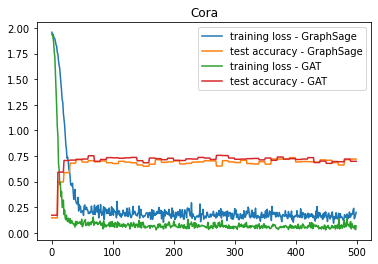

In [11]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

## Question 1.1: What is the maximum accuracy you could get on test set for GraphSage? (10 points)

Submit your answers on Gradescope.  
问题 1.1：您在 GraphSage 测试集上可以获得的最大准确率是多少？ （10分）
在 Gradescope 上提交您的答案。

## Question 1.2: What is the maximum accuracy you could get on test set for GAT? (10 points)

Submit your answers on Gradescope.  
问题 1.2：您在 GAT 测试集上可以获得的最大准确率是多少？ （10分）
在 Gradescope 上提交您的答案。

# 2 DeepSNAP Basics

In previous Colabs we used both of graph class (NetworkX) and tensor (PyG) representations of graphs separately. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as the clustering coefficient and PageRank. To feed the graph into the model, we need to transform the graph into tensor representations including edge tensor `edge_index` and node attributes tensors `x` and `y`. But only using tensors (as the graphs formatted in PyG `datasets` and `data`) will make many graph manipulations and analysis less efficient and harder. So, in this Colab we will use DeepSNAP which combines both representations and offers a full pipeline for GNN training / validation / testing.  
在之前的 Colab 中，我们分别使用了图类 (NetworkX) 和张量 (PyG) 表示。 图类 nx.Graph 提供了丰富的分析和操作功能，例如聚类系数和 PageRank。 为了将图输入模型，我们需要将图转换为张量表示，包括边张量 edge_index 和节点属性张量 x 和 y。 但仅使用张量（如在 PyG 数据集和数据中格式化的图形）会使许多图形操作和分析的效率降低和困难。 因此，在这个 Colab 中，我们将使用 DeepSNAP，它结合了两种表示并为 GNN 训练/验证/测试提供完整的管道。


In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP features in its support for flexible graph manipulation, standard pipeline, heterogeneous graphs and simple API.  
总的来说，DeepSNAP 是一个 Python 库，用于帮助对图进行高效的深度学习。 DeepSNAP 支持灵活的图形操作、标准管道、异构图形和简单的 API。

1. DeepSNAP is easy to be used for the sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before the training.  
DeepSNAP 易于用于复杂的图形操作，例如在训练期间/之前的特征计算、预训练、子图提取等。
2. In most frameworks, standard pipelines for node, edge, link, graph-level tasks under inductive or transductive settings are left to the user to code. In practice, there are additional design choices involved (such as how to split dataset for link prediction). DeepSNAP provides such a standard pipeline that greatly saves repetitive coding efforts, and enables fair comparision for models.  
在大多数框架中，用于在归纳或转导设置下的节点、边、链接、图级任务的标准管道由用户进行编码。 在实践中，还涉及其他设计选择（例如如何拆分数据集以进行链接预测）。 DeepSNAP 提供了这样一个标准管道，大大节省了重复编码工作，并实现了模型的公平比较。
3. Many real-world graphs are heterogeneous graphs. But packages support for heterogeneous graphs, including data storage and flexible message passing, is lacking. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both the node and edge heterogeneity.  
许多现实世界的图是异构图。 但是缺乏对异构图的包支持，包括数据存储和灵活的消息传递。 DeepSNAP 提供了一个高效灵活的异构图，支持节点和边异构。

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)  
DeepSNAP 是一个新发布的项目，仍在开发中。 如果您发现任何错误或有任何改进想法，请随时在 GitHub 上提出问题或创建拉取请求:)

In this Colab, we will focus on DeepSNAP graph manipulations and splitting settings.  
在此 Colab 中，我们将重点介绍 DeepSNAP 图操作和拆分设置。

## Setup

In [12]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

## DeepSNAP Graph

The `deepsnap.graph.Graph` class is the core class of DeepSNAP. It not only represents a graph in tensor format but also references to a graph object from graph manipulation package.deepsnap.graph.  
Graph 类是 DeepSNAP 的核心类。 它不仅表示张量格式的图形，而且还引用了图形操作包中的图形对象。

Currently DeepSNAP supports [NetworkX](https://networkx.org/) and [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) as the back end graph manipulation package.  
目前 DeepSNAP 支持 NetworkX 和 Snap.py 作为后端图形操作包。

In this Colab, we will use the NetworkX as the back end graph manipulation package.  
在这个 Colab 中，我们将使用 NetworkX 作为后端图形操作包。

Lets first try to convert a simple random NetworkX graph to a DeepSNAP graph.  
让我们首先尝试将简单的随机 NetworkX 图转换为 DeepSNAP 图。

(0, {'node_feature': tensor([0.2442, 0.1102, 0.8759, 0.3419, 0.2751]), 'node_label': tensor(0)})


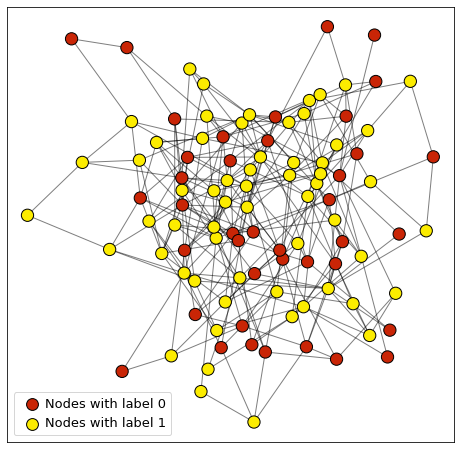

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [13]:
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Print one node example
for node in G.nodes(data=True):
  print(node)
  break

color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

# Visualize the graph
visualize(G, color_map=color_map)

# Transform the networkx graph into the deepsnap graph
graph = Graph(G)

# Print out the general deepsnap graph information
print(graph)

# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# DeepSNAP will also generate the edge_index tensor
print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# Different from only storing tensors, deepsnap graph also references to the networkx graph
# We will discuss why the reference will be helpful later
print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

In DeepSNAP we have three levels of attributes. In this example, we have the **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are graph and edge attributes. The usage is similar to the node level one except that the feature becomes `edge_feature` or `graph_feature` and label becomes `edge_label` or `graph_label` etc.  
在 DeepSNAP 中，我们有三个级别的属性。 在这个例子中，我们有节点级别的属性，包括 node_feature 和 node_label。 另外两个级别的属性是图和边属性。 用法与节点一级相似，只是特征变为edge_feature或graph_feature，label变为edge_label或graph_label等。

Similar to the NetworkX graph, we can easily get some basic information of the graph through class properties directly.  
与 NetworkX 图类似，我们可以直接通过类属性轻松获取图的一些基本信息。

In [14]:
# Number of nodes
print("The random graph has {} nodes".format(graph.num_nodes))

# Number of edges
print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


DeepSNAP also provides functions that can automatically transform the PyG datasets into a list of DeepSNAP graphs.  
DeepSNAP 还提供了可以自动将 PyG 数据集转换为 DeepSNAP 图列表的函数。

Here we transform the CORA dataset into a list of DeepSNAP graphs.  
在这里，我们将 CORA 数据集转换为 DeepSNAP 图的列表。

In [15]:
root = './tmp/cora'
name = 'Cora'

# The Cora dataset
pyg_dataset= Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the first deepsnap graph (CORA only has one graph)
graph = graphs[0]
print(graph)

Processing...
Done!
Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


## Question 2.1: What is the number of classes and number of features in the CORA graph? (5 points)##   
问题 2.1：CORA 图中的类数和特征数是多少？ (5 分)

Submit your answers on Gradescope.

In [16]:
def get_num_node_classes(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node classes of that graph.

  num_node_classes = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_classes = graph.num_node_labels

  ##########################################

  return num_node_classes

def get_num_node_features(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node features of that graph.

  num_node_features = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_features = graph.num_node_features

  ##########################################

  return num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print("{} has {} classes".format(name, num_node_classes))
print("{} has {} features".format(name, num_node_features))

Cora has 7 classes
Cora has 1433 features


## DeepSNAP Dataset

Now, lets talk about DeepSNAP dataset. A `deepsnap.dataset.GraphDataset` contains a list of `deepsnap.graph.Graph` objects. In addition to list of graphs, you can also specify what task the dataset will be used on, such as node level task (`task=node`), edge level task (`task=link_pred`) and graph level task (`task=graph`).  
现在，让我们谈谈 DeepSNAP 数据集。 deepsnap.dataset.GraphDataset 包含 deepsnap.graph.Graph 对象的列表。 除了图表列表，您还可以指定数据集将用于什么任务，例如节点级任务（task=node）、边缘级任务（task=link_pred）和图形级任务（task=graph）。

It also contains many other useful parameters during initialization and other functinoalities. If you are interested, you can take a look at the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).  
它还包含许多其他在初始化和其他功能期间有用的参数。 如果你有兴趣，你可以看看文档。

Lets now use COX2 dataset which contains a list of graphs and specify the task to `graph` when we initialize the DeepSNAP dataset.  
现在让我们使用包含图形列表的 COX2 数据集，并在初始化 DeepSNAP 数据集时将任务指定为 `graph`。

In [17]:
root = './tmp/cox2'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!
GraphDataset(467)


## Question 2.2: What is the label of the graph (index 100 in the COX2 dataset)? (5 points)问题 2.2：图的标签是什么（COX2 数据集中的索引 100）？ (5 分)

Submit your answers on Gradescope.

In [20]:
def get_graph_class(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in the dataset, and returns the class/label 
  # of the graph (in integer).

  label = -1

  ############# Your code here ############
  ## (~1 line of code)
  ## Note
  ## 1. The label refers to the graph-level attribute
  label = dataset[idx].num_graph_labels

  #########################################

  return label

graph_0 = dataset[0]
print(graph_0)
idx = 100
label = get_graph_class(dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph with index 100 has label 1


## Question 2.3: What is the number of edges for the graph (index 200 in the COX2 dataset)? (5 points)问题 2.3：图的边数是多少（COX2 数据集中的索引 200）？ (5 分)

Submit your answers on Gradescope.

In [22]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in dataset, and returns the number of 
  # edges in the graph (in integer).

  num_edges = 0

  ############# Your code here ############
  ## (~1 lines of code)
  ## Note
  ## 1. You can use the class property directly
  num_edges = dataset[idx].num_edges

  #########################################

  return num_edges

idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 49 edges


# 3 DeepSNAP Advanced

We have learned the basic use of DeepSNAP graph and dataset :)  
我们已经学习了 DeepSNAP 图和数据集的基本使用 :)

Lets move on to some more advanced functionalities.  
让我们继续一些更高级的功能。

In this section we will use DeepSNAP for faeture computation and transductive/inductive splittings.  
在本节中，我们将使用 DeepSNAP 进行特征计算和转导/归纳分裂。

## Setup

In [23]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Data Split in Graphs

Data splitting in graphs can be much harder than that in CV or NLP.  
图表中的数据拆分可能比 CV 或 NLP 中的数据拆分困难得多。

In general, the data splitting in graphs can be divided into two settings, **inductive** and **transductive**.  
一般来说，图表中的数据拆分可以分为两种设置，归纳和转导。

## Inductive Split

As what we have learned in the lecture, inductive setting will split multiple graphs into each training/valiation and test sets.  
正如我们在讲座中学到的，归纳设置将多个图拆分为每个训练/验证和测试集。

Here is an example of DeepSNAP inductive splitting for a list of graphs in the graph level task (graph classification etc.)  
以下是图级任务（图分类等）中图列表的 DeepSNAP 归纳拆分示例

In [24]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


## Transductive Split

In transductive setting, the training /validation / test sets are on the same graph.  
在转导设置中，训练/验证/测试集在同一图上。

Here we transductively split the CORA graph in the node level task.   
在这里，我们在节点级任务中转导拆分 CORA 图。

(Notice that in DeepSNAP default setting the split is random, but you can also make a fixed split by specifying `fixed_split=True` when loading the dataset from PyG or changing the `node_label_index` directly).  
（请注意，在 DeepSNAP 默认设置中，拆分是随机的，但您也可以通过在从 PyG 加载数据集或直接更改 node_label_index 时指定 fixed_split=True 来进行固定拆分）。

In [25]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# The nodes in each set can be find in node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


## Edge Level Split

Compared to the node and graph level splitting, edge level splitting is a little bit tricky ;)  
与节点和图级别拆分相比，边级别拆分有点棘手；)

Usually in edge level splitting, we need to sample negative edges, split positive edges into different datasets, split training edges into message passing edges and supervision edges, and resample the negative edges during the training etc.  
通常在边缘级别拆分中，我们需要对负边进行采样，将正边拆分为不同的数据集，将训练边拆分为消息传递边和监督边，并在训练过程中重新采样负边等。

### All Mode

Now lets start with a simpler edge level splitting mode, the `edge_train_mode="all"` mode in DeepSNAP.  
现在让我们从更简单的边缘级别分割模式开始，即 DeepSNAP 中的 edge_train_mode="all" 模式。

In [26]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In DeepSNAP, the indices of supervision edges are stored in `edge_label_index` tensor and the corresponding edge labels are stored in `edge_label` tensor.  
在 DeepSNAP 中，监督边的索引存储在“edge_label_index”张量中，相应的边标签存储在“edge_label”张量中。

In [27]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


We can see that both training and validation sets have the same message passing edges (`edge_index`) in the `all` mode. Also, in training set, the postive supervision edges (`edge_label_index`) are same with the message passing edges. However, in the test set the message passing edges are the combination of message passing edges from training and validation sets.  
我们可以看到，在 all 模式下，训练集和验证集都具有相同的消息传递边（edge_index）。 此外，在训练集中，正监督边（edge_label_index）与消息传递边相同。 但是，在测试集中，消息传递边是来自训练集和验证集的消息传递边的组合。

Notice that the `edge_label` and `edge_label_index` have included the negative edges (default number of negative edges is same with the number of positive edges).  
注意 edge_label 和 edge_label_index 包含了负边（默认负边数与正边数相同）。

Now, lets implement a function that checks whether two edge index tensors are disjoint and explore more edge splitting properties by using that function.  
现在，让我们实现一个函数来检查两个边缘索引张量是否不相交，并使用该函数探索更多的边缘分割属性。

## Question 3.1 - 3.5: Implement the function that checks whether two edge_index tensors are disjoint. Then answer the True/False questions below. (5 points)##   
问题 3.1 - 3.5：实现检查两个 edge_index 张量是否不相交的函数。 然后回答下面的对/错问题。 (5 分)

Submit your answers on Gradescope.

In [28]:
#PRW
s=set()
eg1=tuple(torch.tensor([1,2]).numpy())
eg2=tuple(torch.tensor([1,2]).numpy())
eg3=tuple(torch.tensor([2,1]).numpy())
eg4=tuple(torch.tensor([2,1]).numpy()[::-1])
s.add(eg1)
print(eg1 in s)
print(eg2 in s)
print(eg3 in s)
print(eg4 in s)

True
True
False
True


In [29]:
#PRW
eg1

(1, 2)

In [30]:
#PRW
eg4=torch.tensor([2,1]).numpy()[::-1]
eg4

array([1, 2])

In [31]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  # TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  disjoint = None

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
  ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
  ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
  ## function.
  disjoint = True
  edge_set_1 = set([t for t in edge_index_1.reshape(-1, 2)])
  for t in edge_index_2.reshape(-1, 2):
      if t in edge_set_1:
          disjoint = False
          break

  '''
    #遍历应该会贼慢，所以用集合
  edge_set=set()
  for i in range(edge_index_1.shape[1]):
    e=tuple(edge_index_1[:,i].numpy())
    edge_set.add(e)
  for j in range(edge_index_2.shape[1]):
    e1=tuple(edge_index_2[:,j].numpy())
    if e1 in edge_set:
      return False
    e2=tuple(edge_index_2[:,j].numpy()[::-1])
    if e2 in edge_set:
      return False
  disjoint=True
  '''
  #########################################

  return disjoint

In [32]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


### Disjoint Mode不相交模式

Now lets look at a relatively more complex transductive edge split setting, which is the `edge_train_mode="disjoint"` mode in DeepSNAP (also the transductive link prediction splitting talked in the lecture)  
现在来看一个相对复杂的transductive edge splitting设置，即DeepSNAP中的edge_train_mode="disjoint"模式（也是讲座中讲到的transductive link prediction splitting）

In [33]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


You can see that the training / validation message passing edges and training supervision edges are splitted differently in those two modes!  
您可以看到，在这两种模式下，训练/验证消息传递边缘和训练监督边缘的拆分方式不同！

### Resample Negative Edges

During each training iteration, we usually need to resample the negative edges.  
在每次训练迭代期间，我们通常需要对负边进行重新采样。

Below we print the training and validation sets negative edges in two training iterations.  
下面我们在两次训练迭代中打印训练和验证集的负边。

You should find that the negative edges in training set will be resampled.  
你应该会发现训练集中的负边将被重新采样。

In [34]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration training negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration training negative edges:")
  print(neg_edges_2)
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration validation negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration validation negative edges:")
  print(neg_edges_2)
  break

First iteration training negative edges:
tensor([[2188, 1456,  454,  ...,  182,  664, 1375],
        [1754, 2259,  465,  ...,  813, 1065, 1019]])
Second iteration training negative edges:
tensor([[2418, 1050,  493,  ..., 2240, 1958, 1060],
        [2572,  476, 2487,  ..., 2606,  105,  706]])
First iteration validation negative edges:
tensor([[1739,  312, 1956,  ..., 1143,  883, 2422],
        [ 451,  835, 2115,  ..., 2490, 2613, 1064]])
Second iteration validation negative edges:
tensor([[1739,  312, 1956,  ..., 1143,  883, 2422],
        [ 451,  835, 2115,  ..., 2490, 2613, 1064]])


If you are interested in more graph splitting settings, please refer to the DeepSNAP dataset [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html).  
如果您对更多图形拆分设置感兴趣，请参阅 DeepSNAP 数据集文档。

## Graph Transformation and Feature Computation##   
图变换和特征计算

The other DeepSNAP core functionality is graph transformation / feature computation.  
DeepSNAP 的另一个核心功能是图转换/特征计算。

In DeepSNAP, we divide graph transformation / feature computation into two different types. One is the transformation before training (transform the whole dataset before training directly) and another one is the transformation during training (transform batches of graphs).  
在 DeepSNAP 中，我们将图转换/特征计算分为两种不同的类型。 一种是训练前的转换（直接在训练前转换整个数据集），另一种是训练期间的转换（批量转换图）。

Here is an example that uses NetworkX back end to calculate the PageRank value and update the value to tensors before the training (transform the dataset).  
下面是一个使用 NetworkX 后端计算 PageRank 值并在训练前将值更新为张量的示例（转换数据集）。

In [37]:
def pagerank_transform_fn(graph):

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './tmp/cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


## Question 3.6: Implement the transformation below and report the clustering coefficient of the node (index 3) of the graph (index 406) in the COX2 dataset. Rounded the answer to two decimal places. (5 points)  
问题 3.6：执行下面的变换，并报告 COX2 数据集中图（索引 406）的节点（索引 3）的聚类系数。 将答案四舍五入到小数点后两位。 (5 分)

In [39]:
#PRW
print(type(graphs[0].G))
print(nx.pagerank(graphs[0].G))
print(nx.clustering(graphs[0].G))
print(graphs[0].num_nodes)

<class 'networkx.classes.graph.Graph'>
{0: 0.03320187324334541, 1: 0.03140409249831948, 2: 0.03153195626178245, 3: 0.033999294562979045, 4: 0.03445399167017414, 5: 0.032311799784932586, 6: 0.0325260484487752, 7: 0.03446771688692439, 8: 0.03492764351353999, 9: 0.03400572002885134, 10: 0.03492764351353999, 11: 0.03446771688692439, 12: 0.03491212916795992, 13: 0.035900570307606516, 14: 0.03617171252798891, 15: 0.035900570307606516, 16: 0.03491212916795992, 17: 0.014094182936016601, 18: 0.05033953008328389, 19: 0.048784416428741144, 20: 0.01421311870261539, 21: 0.01421311870261539, 22: 0.05243329098846763, 23: 0.01347941857377365, 24: 0.013607817899048346, 25: 0.013611921935259813, 26: 0.013742454509271822, 27: 0.013742454509271822, 28: 0.013611921935259813, 29: 0.013737355150878086, 30: 0.0140185909846367, 31: 0.0140185909846367, 32: 0.013737355150878086, 33: 0.014542717197278045, 34: 0.014542717197278045, 35: 0.014542717197278045, 36: 0.014987900051433497, 37: 0.014987900051433497, 38: 0

In [40]:
def cluster_transform_fn(graph):
  # TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Compute the clustering coefficient value for each node and
  ## concat them to the last dimension of graph.node_feature
  
  # Get the referenced networkx graph
  G = graph.G

  # Calculate the clustering coefficient by using networkx
  cc = nx.clustering(G)

  # Transform the clustering coefficient values to tensor
  cc_feature = torch.tensor([cc[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  cc_feature = cc_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, cc_feature], dim=-1)

  #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

Extracting cox2/COX2/COX2.zip
Processing...
Done!
The node has clustering coefficient: 0.17


Apart from transforming the dataset, DeepSNAP can also transform the graph (usually the `deepsnap.batch.Batch`) during each training iteration.  
除了转换数据集，DeepSNAP 还可以在每次训练迭代期间转换图（通常是 deepsnap.batch.Batch）。

Also, DeepSNAP supports the synchronization of the transformation between the referenced graph objects and tensor representations. For example, you can just update the NetworkX graph object in the transform function, and by specifying `update_tensor=True` the internal tensor representations will be automatically updated.  
此外，DeepSNAP 支持引用图形对象和张量表示之间转换的同步。 例如，您可以在变换函数中更新 NetworkX 图对象，并通过指定 update_tensor=True 内部张量表示将自动更新。

For more information, please refer to the DeepSNAP [documentation](https://snap.stanford.edu/deepsnap/).  
有关更多信息，请参阅 DeepSNAP 文档。

# 4 Edge Level Prediction

From last section, we know how DeepSNAP transductive split the edges in the link prediction task.  
从上一节中，我们知道 DeepSNAP 转导如何在链接预测任务中分割边。

Now lets use DeepSNAP and PyG together to implement a edge level prediction (link prediction) model!  
现在让我们一起使用 DeepSNAP 和 PyG 来实现边缘级别预测（链接预测）模型！

In [41]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = nn.BCEWithLogitsLoss()

        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product
        out = self.conv1(node_feature, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        out = self.conv2(out, edge_index)
        out = out[edge_label_index[0]] * out[edge_label_index[1]]
        pred = torch.sum(out, -1)
        
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [42]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label.float())
            loss.backward()
            optimizer.step()

            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Your code here #############
    ## (~5 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label
    for i, batch in enumerate(dataloaders['test']):
        batch.to(args["device"])
        pred = model(batch)
        pred = torch.sigmoid(pred)
        score += roc_auc_score(batch.edge_label.cpu().detach().numpy(), pred.cpu().detach().numpy())
    score /= len(dataloaders['test'])
    
    ##########################################
 
    return score

In [43]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [44]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

Epoch: 001, Train: 0.5279, Val: 0.5002, Test: 0.5232, Loss: 0.6930802464485168
Epoch: 002, Train: 0.5306, Val: 0.5174, Test: 0.5404, Loss: 0.6931040287017822
Epoch: 003, Train: 0.5418, Val: 0.5308, Test: 0.5221, Loss: 0.693137526512146
Epoch: 004, Train: 0.5284, Val: 0.5291, Test: 0.5325, Loss: 0.6931036114692688
Epoch: 005, Train: 0.5333, Val: 0.5256, Test: 0.5322, Loss: 0.6931428909301758
Epoch: 006, Train: 0.5409, Val: 0.5193, Test: 0.5269, Loss: 0.6931610703468323
Epoch: 007, Train: 0.5401, Val: 0.5381, Test: 0.5343, Loss: 0.693120002746582
Epoch: 008, Train: 0.5207, Val: 0.5394, Test: 0.5391, Loss: 0.693103551864624
Epoch: 009, Train: 0.5214, Val: 0.5472, Test: 0.5373, Loss: 0.6931371688842773
Epoch: 010, Train: 0.5246, Val: 0.5342, Test: 0.5262, Loss: 0.693080723285675
Epoch: 011, Train: 0.5407, Val: 0.5333, Test: 0.5470, Loss: 0.6930669546127319
Epoch: 012, Train: 0.5485, Val: 0.5461, Test: 0.5381, Loss: 0.6930869817733765
Epoch: 013, Train: 0.5451, Val: 0.5433, Test: 0.5432, Lo

## Question 4: What is the maximum ROC-AUC score you could get for the best_model on test set? (13 points)  
问题 4：对于测试集上的 best_model，您可以获得的最大 ROC-AUC 分数是多少？ (13 分)

Submit your answers on Gradescope.

# Submission

In order to get credit, you must go submit your answers on Gradescope.  
为了获得学分，您必须在 Gradescope 上提交您的答案。

Also, you need to submit the `ipynb` file of Colab 3, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.  
此外，您需要通过单击文件和下载 .ipynb 来提交 Colab 3 的 ipynb 文件。 请确保您的 ipynb 文件中提供了每个单元格的输出。